In [ ]:
%pip install -r .\requirements.txt

In [1]:
import xml.etree.ElementTree as ET
from nltk.stem import RSLPStemmer
import nltk
from zipfile import ZipFile
import pandas as pd
import numpy as np
import unicodedata
import os
import re
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
import torch
from transformers import AutoTokenizer
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import multilabel_confusion_matrix
from wordcloud import WordCloud

c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Caminho dos arquivos extraidos do kaggle
path_dataset = r'files\classificao-de-notcias.zip'
path_db = r'db'

# Caminho dos arquivos que serão utilizados para a atividade
path_train = r'db\arquivos_competicao\arquivos_competicao\train.csv'
path_test = r'db\arquivos_competicao\arquivos_competicao\test.csv'
path_news = r'db\arquivos_competicao\arquivos_competicao\news'


In [3]:
def unzip(path, pathFolder):

    # descompacta a base de dados de notícias
    z = ZipFile(path, 'r')

    if os.path.isdir(pathFolder):
        z.extractall(pathFolder)
        z.close()
    else:
        os.mkdir(pathFolder)
        z.extractall(pathFolder)
        z.close()

    print("Arquivo descompactado com sucesso!")
    
# Antes de descompactar os arquivos valida se ja foram descompactados antes
if not os.path.isdir(path_news):
    unzip(path_dataset, path_db)
else:
    print("Arquivo já descompactado")

Arquivo já descompactado


In [ ]:
def criar_diretorios(caminho):
    # Extrai o diretório do caminho fornecido
    diretorio = os.path.dirname(caminho)
    
    # Cria os diretórios se eles não existirem
    if not os.path.exists(diretorio):
        os.makedirs(diretorio)
        print(f"{diretorio} criado com sucesso")
    else:
        print(f"{diretorio} já existe")
        
    return caminho

---
## Carregando os arquivos de teste e treino

In [4]:
#Carregando os arquivos de treino
df_train = pd.read_csv(path_train)
print("Colunas do arquivo de treino: ", df_train.columns)
print("Quantidade de linhas: ", df_train.shape[0])

Colunas do arquivo de treino:  Index(['ID', 'Class'], dtype='object')
Quantidade de linhas:  2781


In [5]:
# Carregando os arquivos de teste
df_teste = pd.read_csv(path_test)
print("Colunas do arquivo de treino: ", df_teste.columns)
print("Quantidade de linhas: ", df_teste.shape[0])

Colunas do arquivo de treino:  Index(['ID'], dtype='object')
Quantidade de linhas:  1193



### Criando um DataFrame com os textos e titulos extraidos do XML
Para facilitar a aplicação dos metodos foi adicionando novas colunas no DataFrame de treino e teste, contendo o texto e titulo extraidos dos arquivos xml

In [6]:
def extract_xml_text(path_xml):
    
    """
    A função `extract_xml_text` é designada para extrair os textos dos arquivos XML
    especificados pelo `path_xml`.
    Utilizando a biblioteca ElementTree para leitura do arquivo XML 
    """
    
    # Instancia um objeto como uma árvore de análise
    tree = ET.parse(path_xml)
    
    # Obtem o elemento raiz da árvore de ánalise
    root = tree.getroot()
    
    # Encontra o elemento headline (titulo) dentro da árvore de analise
    headline = root.find('headline').text if root.find('headline') is not None else ''
    
    # Entroa todos os elementos <p> que na estrutura dos xml's contem o texto
    paragraphs = root.findall('.//p')
    
    # Junta em uma unica string, separando por espaços
    text = ' '.join([p.text for p in paragraphs if p.text is not None])

    return headline, text

def apply_extraction(df_applyed):

    """
    Essa função é responsável em aplicar as novas colunas 
    no df_applyed passado como parametro.
    """
    
    # Loop pelas linhas do df
    for idx in df_applyed.index:
        
        # atribui o valor da coluna id na variavel file
        file = df_applyed.at[idx, 'ID']
        
        # Concatena o nome do arquivo com o caminho dele
        path_xml = f"{path_news}\{file}"
        
        # Extrai o texto e titulo desse arquivo
        titulo, texto = extract_xml_text(path_xml)
        
        #Atribui esses o texto e titulos em novas colunas
        df_applyed.at[idx, 'TITULO'] = titulo
        df_applyed.at[idx, 'TEXTO'] = texto
    
    return df_applyed

def print_porcentagem(target):
    # Calcula a contagem de cada classe
    class_counts = target['Class'].value_counts()
    
    # Calcula a porcentagem de cada classe
    class_percentages = class_counts / len(target) * 100
    
    # Imprime a porcentagem de cada classe
    for cl, pct in class_percentages.items():
        print(f"Porcentagem da classe {cl}: {round(pct, 2)}%")
        

In [7]:
#Aplicando a função de exracao dos textos do xml no DataFrame de treino
df_train = apply_extraction(df_train)

#Re-organizando as colunas do df
df_train = df_train[['ID', 'TITULO', 'TEXTO', 'Class']]

#Printando as classes e as suas respectativas porcentagens
print_porcentagem(df_train)

Porcentagem da classe Mercados: 74.33%
Porcentagem da classe Economia: 21.18%
Porcentagem da classe GovSocial: 3.24%
Porcentagem da classe CorpIndustrial: 1.26%


---
## Analise Exploratoria

In [8]:
# Verificar se tem valores em branco
missing_values = df_train.isnull().sum()
print(missing_values)

ID        0
TITULO    0
TEXTO     0
Class     0
dtype: int64


Plotando a distribução das classes da coluna targete

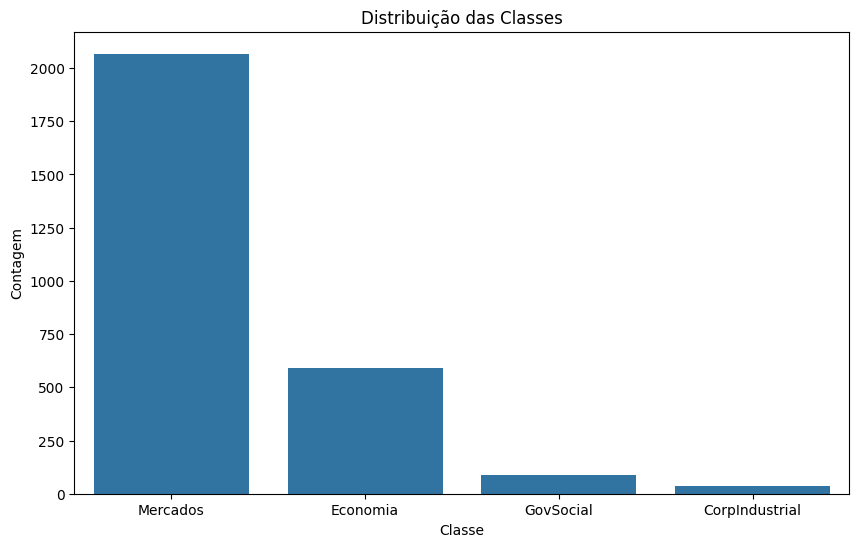

In [9]:
class_counts = df_train['Class'].value_counts()

# Plotar a distribuição das classes
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Distribuição das Classes')
plt.show()

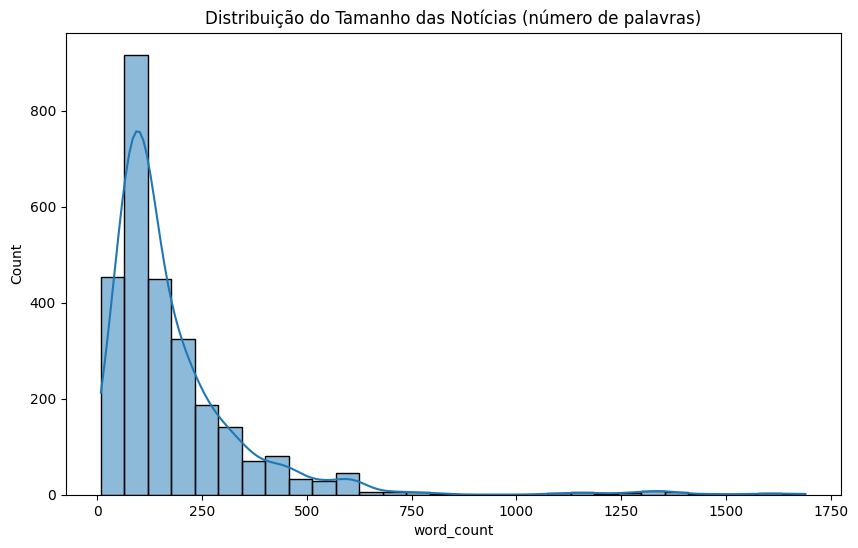

In [10]:
# Tamanho das notícias (número de palavras)
df_train['word_count'] = df_train['TEXTO'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(df_train['word_count'], bins=30, kde=True)
plt.title('Distribuição do Tamanho das Notícias (número de palavras)')
plt.show()

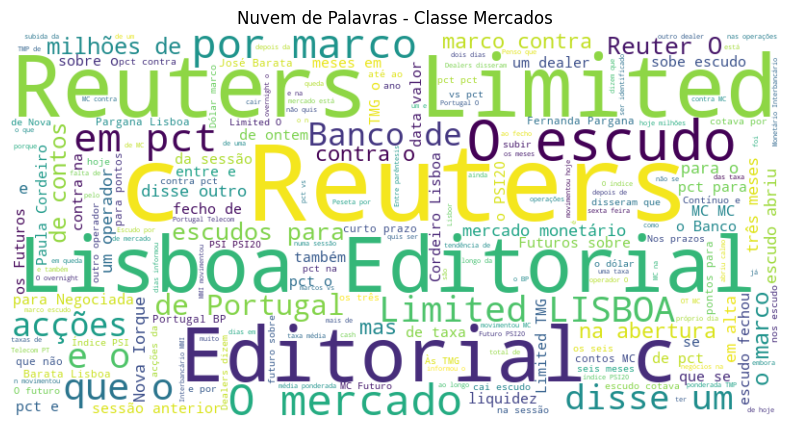

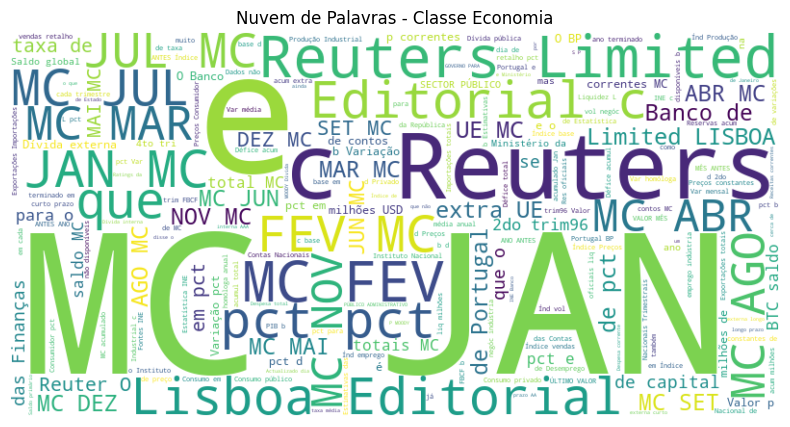

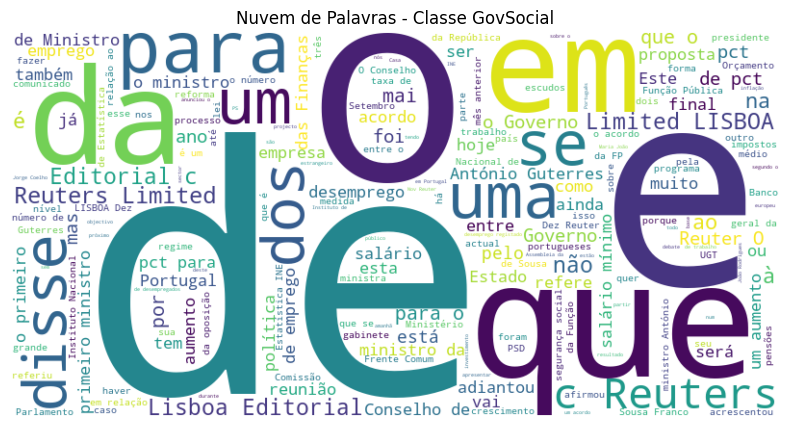

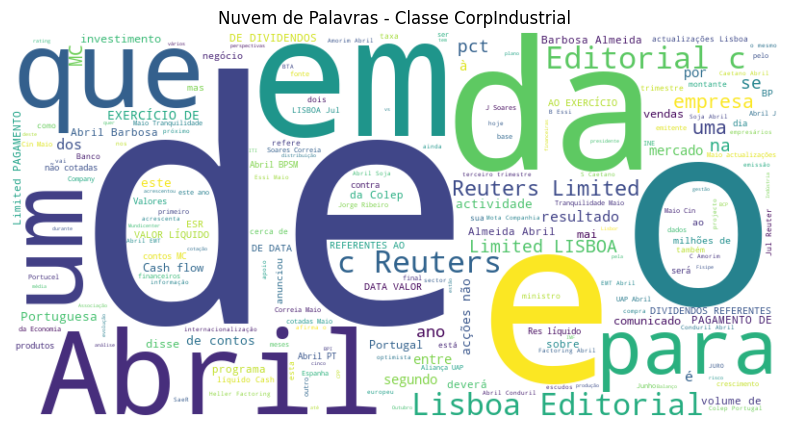

In [11]:
# Função para gerar nuvem de palavras
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Gerar nuvens de palavras para cada classe
for cls in df_train['Class'].unique():
    class_text = ' '.join(df_train[df_train['Class'] == cls]['TEXTO'])
    generate_wordcloud(class_text, f'Nuvem de Palavras - Classe {cls}')


---
## Pré-Processamento dos Dados

In [12]:
def preprocessing_portuguese(text, stemming = False, stopwords = False):
    """
    Funcao usada para tratar textos escritos na lingua portuguesa

    Parametros:
        text: variavel do tipo string que contem o texto que devera ser tratado

        stemming: variavel do tipo boolean que indica se a estemizacao deve ser aplicada ou nao

        stopwords: variavel do tipo boolean que indica se as stopwords devem ser removidas ou nao
    """

    # Lower case
    text = text.lower()

    # remove os acentos das palavras
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

    # remove tags HTML
    regex = re.compile('<[^<>]+>')
    text = re.sub(regex, " ", text)

    # normaliza as URLs
    regex = re.compile('(http|https)://[^\s]*')
    text = re.sub(regex, "<URL>", text)

    # normaliza emails
    regex = re.compile('[^\s]+@[^\s]+')
    text = re.sub(regex, "<EMAIL>", text)

    # converte todos os caracteres não-alfanuméricos em espaço
    regex = re.compile('[^A-Za-z0-9]+')
    text = re.sub(regex, " ", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+.[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+,[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+')
    text = re.sub(regex, "NUMERO", text)


    # substitui varios espaçamentos seguidos em um só
    text = ' '.join(text.split())

    # separa o texto em palavras
    words = text.split()

    # trunca o texto para apenas 200 termos
    words = words[0:200]

    # remove stopwords
    if stopwords:
        words = text.split() # separa o texto em palavras
        words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
        text = " ".join( words )

    # aplica estemização
    if stemming:
        stemmer_method = RSLPStemmer()
        words = [ stemmer_method.stem(w) for w in words ]
        text = " ".join( words )

    # remove palavras compostas por apenas um caracter
    words = text.split() # separa o texto em palavras
    words = [ w for w in words if len(w)>1 ]
    text = " ".join( words )

    return text

### Tratando os textos da base de dados
- Aplicada a função de estemização para a linguagem dos textos (português)
- Removendo os ascentos das palavras
- Criando um limite de 200 temrmos por palavras, para evitar que a predição do classificador seja influenciada pelo tamanho da noticia.

In [13]:
# Download the stopwords corpus
nltk.download('stopwords')

# Download the RSLPStemmer
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [14]:
# Aplicar a função ao DataFrame de treino
df_train['TEXTO'] = df_train['TEXTO'].apply(preprocessing_portuguese)

In [15]:
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_train['TEXTO'],
                                                    df_train['Class'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_train['Class'])

### Transformando a coluna target para valores numericos

In [16]:
# Transformação do target para one-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train = one_hot_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test = one_hot_encoder.fit_transform(y_test.values.reshape(-1, 1))

---
## Técnicas de representação vetorial

### Word Embeddings (treinada com a própria base)
Os word embeddings é uma técnica avançada de representação vetorial de palavras que capturam o significado semântico e as relações entre palavras em um espaço vetorial de alta dimensão.

In [17]:
# Tokenização dos textos de treinamento
train_documents = [text.split() for text in X_train]

# Tokenização dos textos de teste
test_documents = [text.split() for text in X_test]

print("20 primeiras palavras da primeira amostra de treino")
print(train_documents[0][0:30])

print("\n20 primeiras palavras da primeira amostra de teste")
print(test_documents[0][0:30])

20 primeiras palavras da primeira amostra de treino
['lisboa', 'NUMERO', 'mar', 'reuter', 'banco', 'de', 'portugal', 'deve', 'manter', 'inalteradas', 'todas', 'as', 'suas', 'taxas', 'directoras', 'no', 'inicio', 'do', 'proximo', 'periodo', 'de', 'reservas', 'consideram', 'sete', 'de', 'um', 'conjunto', 'de', 'NUMERO', 'economistas']

20 primeiras palavras da primeira amostra de teste
['escudo', 'fechou', 'em', 'alta', 'contra', 'marco', 'numa', 'sessao', 'volatil', 'marcada', 'pela', 'forte', 'probabilidade', 'da', 'reentrada', 'da', 'lira', 'no', 'mtc', 'do', 'sme', 'dealers', 'disseram', 'que', 'escudo', 'devera', 'manter', 'se', 'colado', 'aos']


A função **Word2Vec** foi utilizada para treinar o modelo de word embeddings utilizando os seguintes paramentros:
- **sentences**: a lista das listas de palavras tokenizadas anteriormente
- **vector_size=200**: define que cada vetor tera 200 dimensões
- **window=3**: considera 3 palavras à esquerda e 3 palavras à direita da palavra-alvo
- **min_count=1**: inclui todas as palavras que aparecem pelo menos uma vez
- **workers=4**: usa 4 threads para o treinamento

In [18]:
w2v_model = Word2Vec(train_documents,
                     vector_size=200,
                     window=3,
                     min_count=1,
                     workers=4)

print("Tamanho do vocabulario do modelo: ", len(w2v_model.wv))

Tamanho do vocabulario do modelo:  9510


In [19]:
def getDocvector(model, doc):
    # Inicializa uma lista para armazenar os vetores das palavras
    wordList = []
    
    # Itera sobre cada palavra no documento
    for word in doc:
        try:
            # Tenta obter o vetor da palavra do modelo Word2Vec
            vec = model.wv[word]
            # Adiciona o vetor da palavra à lista
            wordList.append(vec)
        except:
            # Se a palavra não estiver no vocabulário do modelo, ignora
            pass
    
    # Se a lista de vetores de palavras não estiver vazia
    if len(wordList) > 0:
        # Calcula a média dos vetores das palavras para representar o documento
        vetorMedio = np.mean(wordList, axis=0)
    else:
        # Se nenhuma palavra do documento estiver no vocabulário do modelo,
        # retorna um vetor de zeros com o mesmo tamanho dos vetores do modelo
        vetorMedio = np.zeros(model.wv.vector_size)
    
    # Retorna o vetor médio do documento
    return vetorMedio

In [20]:
def dataset2featureMatrix(dataset, embeddingModel):
    # Inicializa uma lista para armazenar os embeddings dos documentos
    X_embedding = []
    
    # Itera sobre cada documento no dataset
    for doc in dataset:
        # Obtém o vetor médio do documento usando a função getDocvector
        vec = getDocvector(embeddingModel, doc)
        # Adiciona o vetor do documento à lista de embeddings
        X_embedding.append(vec)
    
    # Converte a lista de embeddings em um array NumPy
    X_embedding = np.array(X_embedding)
    
    # Retorna a matriz de features
    return X_embedding

In [21]:
# Representação Vetorial com Word2Vec treinado na própria base
X_train_embedding = dataset2featureMatrix(train_documents, w2v_model)
X_test_embedding = dataset2featureMatrix(test_documents, w2v_model)

print(X_train_embedding.shape)
print(X_test_embedding.shape)

(2224, 200)
(557, 200)


### Word Embeddings (pré-treinadas)
Para esse caso será utilizado um modelo pré-treinado para português postado no Hugging Face, chamado [BERTimbau](https://huggingface.co/neuralmind/bert-base-portuguese-cased)

In [22]:
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [23]:
def mean_pooling(model_output, attention_masks):
    # Extrai os embeddings dos tokens da saída do modelo
    tokenEmbeddings = model_output[0]

    # Expande a máscara de atenção para ter as mesmas dimensões que os embeddings dos tokens
    inputExpandido = attention_masks.unsqueeze(-1).expand(tokenEmbeddings.size())

    # Converte a máscara de atenção expandida para float
    inputExpandido = inputExpandido.float()

    # Calcula a média ponderada dos embeddings dos tokens
    # Multiplica os embeddings dos tokens pela máscara de atenção expandida
    # Depois soma os embeddings ao longo da dimensão dos tokens (dimensão 1)
    # Divide pela soma das máscaras de atenção para normalizar
    saida = (torch.sum(tokenEmbeddings * inputExpandido, 1) /
             torch.clamp(inputExpandido.sum(1), min=0.0000001))

    # Retorna os embeddings da sentença
    return saida

In [24]:
def get_docVec(model, tokenizer, doc):
    # Tokeniza o documento, adicionando padding e truncamento, e converte para tensores PyTorch
    encoded = tokenizer(doc,
                        padding=True,
                        truncation=True,
                        max_length=200,
                        return_tensors="pt")

    # Desabilita a computação de gradiente para economizar memória e acelerar a inferência
    with torch.no_grad():
        # Gera a saída do modelo BERT para o documento tokenizado
        model_output = model(**encoded)

    # Calcula o embedding da sentença usando a média ponderada dos embeddings dos tokens
    sentenceEmbedding = mean_pooling(model_output, encoded['attention_mask'])

    # Converte o embedding da sentença para um array NumPy
    sentenceEmbedding = sentenceEmbedding.squeeze().numpy()

    # Retorna o embedding da sentença
    return sentenceEmbedding

In [25]:
def dataset2featureMatrixBert(dataset, model, tokenizer):
    # Inicializa uma lista para armazenar os embeddings dos documentos
    X_embedding = []

    # Itera sobre cada documento no dataset
    for doc in dataset:
        # Obtém o vetor médio do documento usando a função get_docVec
        vec = get_docVec(model, tokenizer, doc)
        # Adiciona o vetor do documento à lista de embeddings
        X_embedding.append(vec)

    # Converte a lista de embeddings em um array NumPy
    return np.array(X_embedding)

In [26]:
# Geração das representações vetoriais para os conjuntos de treinamento e teste
X_train_embedding_bert = dataset2featureMatrixBert(X_train, model, tokenizer)
X_test_embedding_bert = dataset2featureMatrixBert(X_test, model, tokenizer)

print("Dimensões dos embeddings de treinamento:", X_train_embedding_bert.shape)
print("Dimensões dos embeddings de teste:", X_test_embedding_bert.shape)

Dimensões dos embeddings de treinamento: (2224, 768)
Dimensões dos embeddings de teste: (557, 768)


_______
# Treinando o modelo neural perceptron multicamadas (MLP - multi layer perceptron)

In [27]:
# Definindo o modelo MLP
def build_mlp_model(input_layer_size, hidden_layer_size, output_layer_size, dropout_rate=0.5, regularization_rate=0.01):
    model = Sequential()
    
    # Camada de entrada e primeira camada oculta
    model.add(Dense(units=hidden_layer_size, input_dim=input_layer_size, activation='relu', 
                    kernel_regularizer=L2(regularization_rate)))
    model.add(Dropout(dropout_rate))
    
    # Camada de saída
    model.add(Dense(units=output_layer_size, activation='softmax'))
    
    return model

# Variáveis de entrada e saída
input_layer_size = X_train_embedding_bert.shape[1]
hidden_layer_size = input_layer_size
output_layer_size = 4

# Construção do modelo
model = build_mlp_model(input_layer_size, hidden_layer_size, output_layer_size)

# Otimizador
optimizer = SGD(learning_rate=0.001)

# Compilação do modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(X_train_embedding_bert, y_train, epochs=500, batch_size=250, validation_split=0.2, verbose=0)

# Previsão e cálculo do AUC
y_pred_proba = model.predict(X_test_embedding_bert)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
print(f"AUC: {auc:.4f}")


c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC: 0.9429


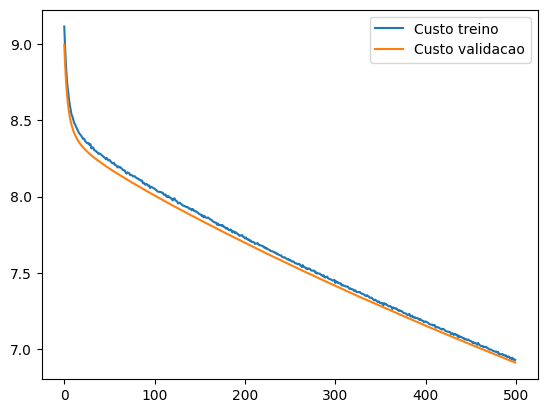

In [28]:
df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']

df.plot()
plt.show()

---
## Escolha dos Hiperparâmetros

In [29]:
# Função para realizar a busca de hiperparâmetros (Grid Search ou Random Search)
def buscar_melhores_hiperparametros(X_train, y_train, metodo='grid'):
    # Definindo o espaço de hiperparâmetros
    param_grid = {
        'hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],
        'activation': ['logistic', 'relu'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
    }
    
    # Instanciando o modelo MLP
    mlp = MLPClassifier(random_state=42, max_iter=500)
    
    # Definindo o scorer AUC
    auc_scorer = make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True)
    
    if metodo == 'grid':
        # Configurando a busca em grade com validação cruzada
        search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=auc_scorer)
    elif metodo == 'random':
        # Configurando a busca aleatória com validação cruzada
        search = RandomizedSearchCV(estimator=mlp, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42, scoring=auc_scorer)

    # Treinando a busca de hiperparâmetros
    search.fit(X_train, y_train)
    
    # Retornando os melhores parâmetros e o melhor modelo
    return search.best_params_, search.best_estimator_

# Função para classificar e avaliar o modelo com os melhores hiperparâmetros encontrados
def classificar_com_melhores_hiperparametros(X_train, X_test, y_train, y_test, metodo='grid'):
    # Encontrando os melhores hiperparâmetros
    melhores_parametros, best_model = buscar_melhores_hiperparametros(X_train, y_train, metodo)
    print(f"Melhores Hiperparâmetros: {melhores_parametros}")
    
    # Fazendo previsões no conjunto de teste
    y_pred = best_model.predict(X_test)
    
    # Avaliando a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {accuracy:.4f}")
    
    # Relatório de classificação
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
    
    # Calculando a matriz de confusão manualmente
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    for i, cm in enumerate(mcm):
        print(f"\nMatriz de Confusão para a classe {i}:\n", cm)
    
    # Calculando a AUC
    y_proba = best_model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovo')
    print(f"AUC: {auc:.4f}")
    
    return best_model

In [30]:
# Usando as funções com MLP com as embeddigs treinadas localmente
best_model_embeddings = classificar_com_melhores_hiperparametros(X_train_embedding, X_test_embedding, y_train, y_test, 'random')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores Hiperparâmetros: {'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'relu'}
Acurácia: 0.9425

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.85      0.93      0.89       118
           2       0.62      0.28      0.38        18
           3       0.98      0.99      0.99       414

   micro avg       0.95      0.95      0.95       557
   macro avg       0.86      0.66      0.71       557
weighted avg       0.94      0.95      0.94       557
 samples avg       0.94      0.95      0.94       557


Matriz de Confusão para a classe 0:
 [[550   0]
 [  4   3]]

Matriz de Confusão para a classe 1:
 [[419  20]
 [  8 110]]

Matriz de Confusão para a classe 2:
 [[536   3]
 [ 13   5]]

Matriz de Confusão para a classe 3:
 [[136   7]
 [  5 409]]
AUC: 0.9865


c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
# Usando as funções com MLP com as embeddigs pré treinadas
best_model_embeddings_bert = classificar_com_melhores_hiperparametros(X_train_embedding_bert, X_test_embedding_bert, y_train, y_test, 'random')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores Hiperparâmetros: {'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
Acurácia: 0.9605

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.92      0.92      0.92       118
           2       0.94      0.89      0.91        18
           3       0.98      0.99      0.99       414

   micro avg       0.96      0.97      0.97       557
   macro avg       0.88      0.84      0.86       557
weighted avg       0.96      0.97      0.97       557
 samples avg       0.96      0.97      0.97       557


Matriz de Confusão para a classe 0:
 [[548   2]
 [  3   4]]

Matriz de Confusão para a classe 1:
 [[430   9]
 [  9 109]]

Matriz de Confusão para a classe 2:
 [[538   1]
 [  2  16]]

Matriz de Confusão para a classe 3:
 [[135   8]
 [  3 411]]
AUC: 0.9926


c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---
## Previsão do conjunto de teste

In [40]:
# Função para preparar os dados de teste
def prepare_test_data(df_test):
    # Aplicar a função de extração de textos do XML no DataFrame de teste
    df_test = apply_extraction(df_test)
    
    # Re-organizar as colunas do DataFrame
    df_test = df_test[['ID', 'TITULO', 'TEXTO']]
    
    # Aplicar a função de pré-processamento no texto das amostras de teste
    df_test['TEXTO'] = df_test['TEXTO'].apply(preprocessing_portuguese)
    
    return df_test

In [41]:
# Função para treinar e avaliar o modelo com os melhores hiperparâmetros encontrados
def classificar_e_treinar_com_melhores_hiperparametros(X_train, X_val, y_train, y_val, metodo='random'):
    # Encontrando os melhores hiperparâmetros
    melhores_parametros, best_model = buscar_melhores_hiperparametros(X_train, y_train, metodo)
    print(f"Melhores Hiperparâmetros: {melhores_parametros}")
    
    # Fazendo previsões no conjunto de validação
    y_pred = best_model.predict(X_val)
    
    # Avaliando a acurácia
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Acurácia: {accuracy:.4f}")
    
    # Relatório de classificação
    print("\nRelatório de Classificação:\n", classification_report(y_val, y_pred, zero_division=0))
    
    # Matriz de confusão
    print("\nMatriz de Confusão:\n")
    for i in range(len(best_model.classes_)):
        cm = confusion_matrix(y_val[:, i], y_pred[:, i])
        print(f"Matriz de Confusão para a classe {i}:\n", cm)
    
    # Calculando a AUC
    y_proba = best_model.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_proba, multi_class='ovo')
    print(f"AUC: {auc:.4f}")
    
    return best_model

In [42]:
def generate_submission_file_mlp_bert(classifier, X_test_embedding, df_test, filename='submission.csv'):
    # Fazer previsões no conjunto de teste
    y_proba = classifier.predict_proba(X_test_embedding)

    # Criar um DataFrame com as probabilidades
    submission_df = pd.DataFrame(y_proba, columns=['CorpIndustrial', 'Economia', 'GovSocial', 'Mercados'])

    # Adicionar a coluna ID
    submission_df.insert(0, 'ID', df_test['ID'])

    # Garantir que o formato está correto, com as probabilidades para cada classe
    submission_df['ID'] = submission_df['ID'].apply(lambda x: x.split('/')[-1])  # Ajustar se necessário

    # Salvar o DataFrame como um arquivo CSV
    submission_df.to_csv(filename, index=False, float_format='%.5f')
    print(f"Arquivo de submissão salvo como {filename}")

In [43]:
df_teste = prepare_test_data(df_teste)

In [44]:
# Geração das representações vetoriais para os conjuntos de teste
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
X_test_embedding_bert = dataset2featureMatrixBert(df_teste['TEXTO'], model, tokenizer)

In [45]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train_embedding_bert, y_train, test_size=0.2, random_state=42, stratify=y_train)
best_model_bert = classificar_e_treinar_com_melhores_hiperparametros(X_train_part, X_val_part, y_train_part, y_val_part, metodo='random')

c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores Hiperparâmetros: {'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'logistic'}
Acurácia: 0.9506

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.92      0.94      0.93        94
           2       0.91      0.71      0.80        14
           3       0.99      0.99      0.99       331

   micro avg       0.97      0.96      0.96       445
   macro avg       0.83      0.70      0.74       445
weighted avg       0.96      0.96      0.96       445
 samples avg       0.95      0.96      0.96       445


Matriz de Confusão:

Matriz de Confusão para a classe 0:
 [[438   1]
 [  5   1]]
Matriz de Confusão para a classe 1:
 [[343   8]
 [  6  88]]
Matriz de Confusão para a classe 2:
 [[430   1]
 [  4  10]]
Matriz de Confusão para a classe 3:
 [[110   4]
 [  4 327]]
AUC: 0.9939


c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [46]:
# Gerar o arquivo de submissão usando o modelo MLP treinado com BERT embeddings
submission_file = r'submission_files/mlp/'
generate_submission_file_mlp_bert(best_model_embeddings_bert, X_test_embedding_bert, df_teste, filename=submission_file+'submission_bert.csv')

Arquivo de submissão salvo como submission_files/mlp/submission_bert.csv
